In [1]:
#encoding="utf-8"
import requests
import json
import pandas as pd
import numpy as np
import time

c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\administrator\anaconda3\envs\myproject\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
#获取永续合约持仓
def future_position(platform,symbol):
    if platform=="binance":
        url='https://dapi.binance.com/futures/data/openInterestHist'
        #now = int(time.time())-86400 *29
        data={'symbol':symbol,'period':'1d',"pair":"{}USD".format(symbol)}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()
                    df[symbol]=[float(i['sumOpenInterestValue']) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["timestamp"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df  
    elif platform=="huobi":
        url='https://api.btcgateway.pro/swap-api/v1/swap_his_open_interest'
        data={'contract_code':"{}-usd".format(symbol).upper(),"period":"1day","amount_type":2}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()['data']['tick']
                    df[symbol]=[float(i['volume']) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d",time.localtime(i["ts"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df

In [3]:
# 获取火币或者T8或者币安历史合约K线数据
def get_future_klinedata0(platform, symbol):
    if platform == 'huobi':
        try:
            now = int(time.time())
            start_time = now - 86400*30
            contract_code = "{}-usdt".format(symbol).upper()
            url ='https://api.btcgateway.pro/linear-swap-ex/market/history/kline?contract_code={}&period=1day&from={}&to={}'.format(
                contract_code, start_time, now)
            res = requests.get(url)
            resdict = json.loads(res.content.decode())
            df = pd.DataFrame()
            df['close'] = [i['close'] for i in resdict['data']]
            df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i['id'])) for i in resdict['data']]
        except Exception as e:
            print(e)
            df = pd.DataFrame()
        finally:
            return df
    elif platform == "T8ex":
        try:
            contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8,
                                'DOGE': 9}
            contract_id = contract_id_dict[symbol.upper()]
            now = int(time.time())
            start_time = now - 86400*30
            url = T8ex_kline_url + "?contractId={}&from={}&to={}&resolution={}".format(contract_id, start_time * 1000,now * 1000,"1D")
            res = requests.get(url).json()
            df = pd.DataFrame()
            df['close'] = [i[4] for i in res]
        except Exception as e:
            df = pd.DataFrame()
        finally:
            return df

    elif platform == "binance":
        for _ in range(3):
            url = 'https://www.binancezh.com/dapi/v1/continuousKlines'
            pair = "{}usd".format(symbol).upper()
            now = int(time.time())
            start_time = now - 86400 *30
            df = pd.DataFrame()
            data = {'pair': pair, 'contractType': "PERPETUAL", 'interval': '1d', 'starttime': start_time * 1000,'endtime': now * 1000}
            try:
                response = requests.get(url, params=data, timeout=1)
                if response.status_code==200:
                    res=response.json()
                    #print(res)
                    df = pd.DataFrame()
                    df['close'] = [float(i[4]) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(int(i[0])/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df

In [4]:
#持仓多空比
def top_position_ratio(platform,symbol):
    if platform=="binance":
        url='https://dapi.binance.com/futures/data/topLongShortPositionRatio'
        data={'symbol':symbol,'period':'1d',"pair":"{}USD".format(symbol)}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                res=requests.get(url,params=data)
                if res.status_code==200:
                    res=res.json()
                    df['longratio']=[float(i['longPosition']) for i in res]
                    df['shortratio']=[float(i['shortPosition']) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d",time.localtime(i["timestamp"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
                pass
        return df
    elif platform=="huobi":
        url='https://api.btcgateway.pro/linear-swap-api/v1/swap_elite_position_ratio'
        data={'contract_code':"{}-USDT".format(symbol.upper()),"period":"1day"}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                res=requests.get(url,params=data)
                if res.status_code==200:
                    res=res.json()['data']['list']
                    df['longratio']=[float(i['buy_ratio']) for i in res]
                    df['shortratio']=[float(i['sell_ratio']) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["ts"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df

In [5]:
contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8,'DOGE': 9}
symbol="DOGE"
df=top_position_ratio("huobi",symbol)
df_close=get_future_klinedata0("huobi",symbol)

In [6]:
df['long_change']=df['longratio']-df['longratio'].shift()

In [7]:
df=pd.merge(df_close,df,how="left",on='time')

In [8]:
df['return']=np.log(df['close']/df['close'].shift())

In [9]:
df['direction']=np.where(df['long_change']>0,1,-1)

In [10]:
df.dropna(inplace=True)

In [11]:
df

,close,time,longratio,shortratio,long_change,return,direction
2,0.292851,2021-08-25 00:00:00,0.378,0.622,-0.024,-0.003225,-1
3,0.270480,2021-08-26 00:00:00,0.383,0.617,0.005,-0.079466,1
4,0.284947,2021-08-27 00:00:00,0.366,0.634,-0.017,0.052105,-1
5,0.286034,2021-08-28 00:00:00,0.408,0.592,0.042,0.003807,1
6,0.279431,2021-08-29 00:00:00,0.393,0.607,-0.015,-0.023355,-1
7,0.276880,2021-08-30 00:00:00,0.392,0.608,-0.001,-0.009171,-1
8,0.278559,2021-08-31 00:00:00,0.396,0.604,0.004,0.006046,1
9,0.281392,2021-09-01 00:00:00,0.379,0.621,-0.017,0.010119,-1
10,0.296031,2021-09-02 00:00:00,0.393,0.607,0.014,0.050715,1
11,0.301318,2021-09-03 00:00:00,0.437,0.563,0.044,0.017702,1


In [12]:
df['strategy']=df['return']*(df['direction'].shift())

<AxesSubplot:>

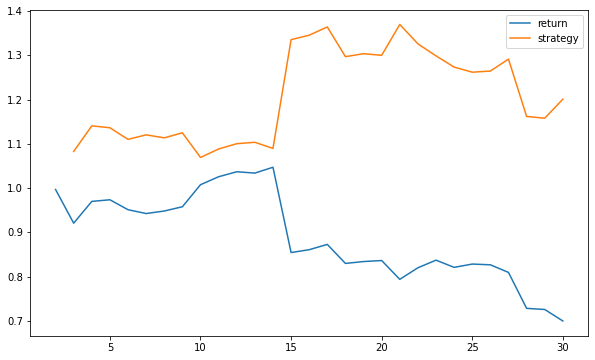

In [13]:
df[['return','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [28]:
#获取永续合约持仓
def future_position(platform,symbol):
    if platform=="binance":
        url='https://dapi.binance.com/futures/data/openInterestHist'
        #now = int(time.time())-86400 *29
        data={'symbol':symbol,'period':'1d',"pair":"{}USD".format(symbol)}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()
                    df[symbol]=[float(i['sumOpenInterest']) for i in res]
                    #df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["timestamp"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df 
    elif platform=="huobi":
        url='https://api.btcgateway.pro/linear-swap-api/v1/swap_his_open_interest'
        data={'contract_code':'{}-usdt'.format(symbol).upper(),'period':'1day',"amount_type":1}
        df=pd.DataFrame()
        for _ in range(3):
            try:
                response=requests.get(url,params=data)
                if response.status_code==200:
                    res=response.json()['data']['tick']
                    df[symbol]=[float(i['value']) for i in res]
                    df['time']=[time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(i["ts"]/1000)) for i in res]
                    break
            except Exception as e:
                print(e)
        return df

In [29]:
#获得多个币种近30日的持仓详情
def get_all_position(symbols):
    all_position=None
    for symbol in symbols:
        df=future_position("huobi",symbol)
        all_position=df if all_position is None else pd.concat([all_position,df],axis=1)
    return all_position

In [171]:
symbols = ['btc','eth','link','eos','fil','ltc','dot','doge','uni']
symbol=symbols[6]
df=future_position("huobi",symbol)
df_close=get_future_klinedata0("huobi",symbol)

In [172]:
df['pos_change']=df[symbol]-df[symbol].shift()

In [173]:
#仓单因子
# def ware_house_factor(symbols,df):
#     ware_house_list=None
#     for symbol in symbols:
#         ware_house_pct=pd.DataFrame({symbol:[(float(df[symbol].iloc[-1])-float(df[symbol].iloc[0]))/float(df[symbol].iloc[0])]})
#         ware_house_list =ware_house_pct.T if ware_house_list is None else pd.concat([ware_house_list,ware_house_pct.T],axis=0)
#     ware_house_list.columns=['position_change']
#     ware_house_list.sort_values(by=['position_change'],ascending=False,inplace=True)
#     ware_house_list.dropna(inplace=True)
#     return ware_house_list

In [174]:
df=pd.merge(df_close,df,how="left",on='time')

In [175]:
df

,close,time,dot,pos_change
0,27.6705,2021-08-23 00:00:00,1.944712e+07,2.340956e+05
1,25.9306,2021-08-24 00:00:00,1.921303e+07,2.229300e+05
2,26.2067,2021-08-25 00:00:00,1.899010e+07,8.147370e+05
3,24.0892,2021-08-26 00:00:00,1.817536e+07,-2.126428e+06
4,25.8798,2021-08-27 00:00:00,2.030179e+07,-8.757376e+04
5,25.8302,2021-08-28 00:00:00,2.038936e+07,1.765980e+05
6,25.7310,2021-08-29 00:00:00,2.021276e+07,2.760489e+05
7,25.1177,2021-08-30 00:00:00,1.993671e+07,-4.610485e+05
8,30.9735,2021-08-31 00:00:00,2.039776e+07,-6.242586e+06
9,30.1662,2021-09-01 00:00:00,2.664035e+07,6.253122e+06


In [176]:
df['return']=np.log(df['close']/df['close'].shift())

In [177]:
df['direction']=np.where(df['pos_change']>0,1,-1)

In [178]:
df.dropna(inplace=True)

<AxesSubplot:>

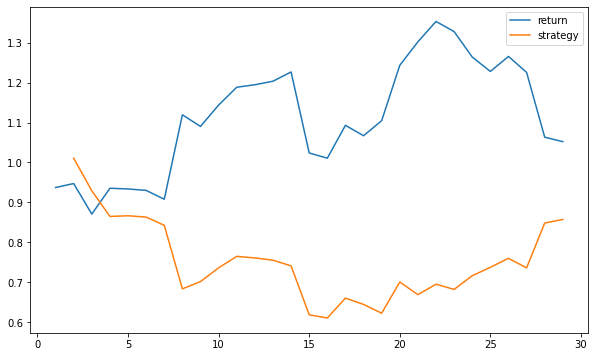

In [179]:
df['strategy']=df['return']*(df['direction'].shift())
df[['return','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))